In [15]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import random_split, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# 1. Download and Preprocess
transform = Compose(
    [ToTensor(), Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
)

cifar10_train = datasets.CIFAR10(
    root="cifar10/", train=True, download=True, transform=transform
)
cifar10_test = datasets.CIFAR10(
    root="cifar10/", train=False, download=True, transform=transform
)

# 2. Find size, shape, and classes
print(f"Size of training dataset: {len(cifar10_train)}")
print(f"Size of test dataset: {len(cifar10_test)}")
print(f"Shape of images: {cifar10_train[0][0].shape}")
print(f"Classes: {cifar10_train.classes}")

Files already downloaded and verified
Files already downloaded and verified
Size of training dataset: 50000
Size of test dataset: 10000
Shape of images: torch.Size([3, 32, 32])
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training Images:
Test Images:


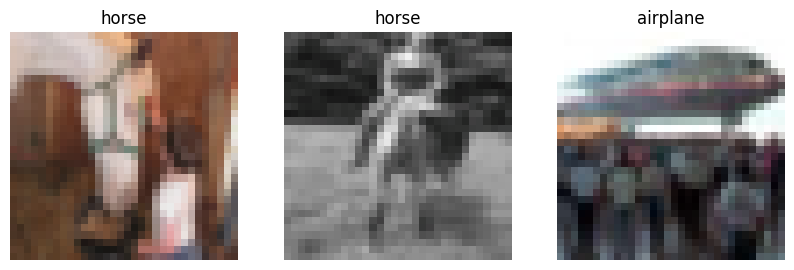

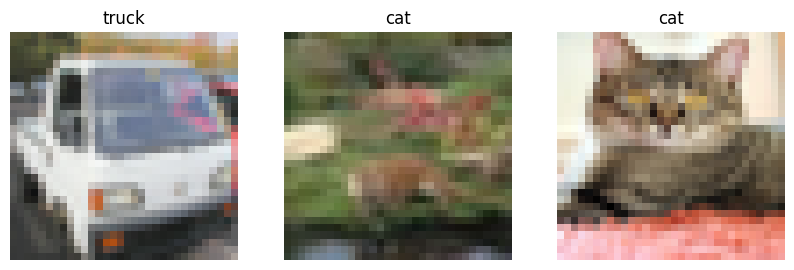

In [16]:
# 3. Visualize Random Images
def show_images(dataset, num_images=3):
    figure = plt.figure(figsize=(10, 8))
    for i in range(num_images):
        idx = torch.randint(0, len(dataset), size=(1,)).item()
        img, label = dataset[idx]
        figure.add_subplot(1, num_images, i + 1)
        plt.title(dataset.classes[label])
        plt.axis("off")
        # Denormalize and display
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]) + torch.tensor(
            [0.4914, 0.4822, 0.4465]
        )
        plt.imshow(img)


print("Training Images:")
show_images(cifar10_train)

print("Test Images:")
show_images(cifar10_test)

In [17]:
# 4. Split Training Dataset for Validation
train_size = int(0.8 * len(cifar10_train))
val_size = len(cifar10_train) - train_size

train_dataset, val_dataset = random_split(cifar10_train, [train_size, val_size])

# 5. Data Loaders
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader,
}

print("Data loaders have been created!")

Data loaders have been created!


In [18]:
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for each image
        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layers with ReLU activation and dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

model = CIFAR10_CNN()
print(model)


CIFAR10_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(num_epochs, cnn, loaders, optimizer, loss_func, device):
    cnn.train()

    train_losses = []
    val_losses = []

    total_step = len(loaders["train"])
    for epoch in range(num_epochs):
        # Training
        train_loss = 0.0
        for i, (images, labels) in enumerate(loaders["train"]):
            images, labels = images.to(device), labels.to(device) # Move images and labels to current device
            
            # Forward pass
            outputs = cnn(images)
            loss = loss_func(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            if (i+1) % 100 == 0:
                print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        train_losses.append(train_loss / total_step)
        
        # Validation loss
        cnn.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in loaders["val"]:
                images, labels = images.to(device), labels.to(device)
                outputs = cnn(images)
                loss = loss_func(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(loaders["val"]))
        
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


In [20]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

num_epochs = 10
train_losses, val_losses = train(num_epochs, model, loaders, optimizer, loss_func, device)


Epoch [1/10], Step [100/400] Loss: 1.7981
Epoch [1/10], Step [200/400] Loss: 1.6225
Epoch [1/10], Step [300/400] Loss: 1.3602
Epoch [1/10], Step [400/400] Loss: 1.2932
Epoch [1/10] Train Loss: 1.5906, Validation Loss: 1.2690
Epoch [2/10], Step [100/400] Loss: 1.1396
Epoch [2/10], Step [200/400] Loss: 0.9731
Epoch [2/10], Step [300/400] Loss: 0.8541
Epoch [2/10], Step [400/400] Loss: 0.8161
Epoch [2/10] Train Loss: 1.0233, Validation Loss: 0.9105
Epoch [3/10], Step [100/400] Loss: 0.7797
Epoch [3/10], Step [200/400] Loss: 0.7660
Epoch [3/10], Step [300/400] Loss: 0.7603
Epoch [3/10], Step [400/400] Loss: 0.8082
Epoch [3/10] Train Loss: 0.8005, Validation Loss: 0.7971
Epoch [4/10], Step [100/400] Loss: 0.6846
Epoch [4/10], Step [200/400] Loss: 0.6877
Epoch [4/10], Step [300/400] Loss: 0.6504
Epoch [4/10], Step [400/400] Loss: 0.5757
Epoch [4/10] Train Loss: 0.6468, Validation Loss: 0.7961
Epoch [5/10], Step [100/400] Loss: 0.4435
Epoch [5/10], Step [200/400] Loss: 0.5405
Epoch [5/10], St

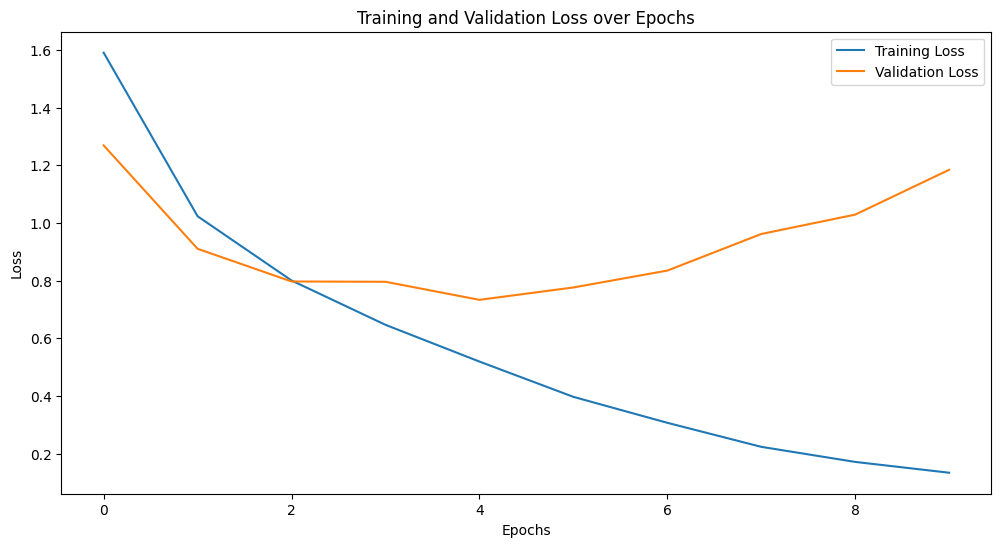

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss over Epochs")
plt.show()


In [22]:
def test_model(cnn, loaders, device):
    cnn.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in loaders["test"]:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Calculate per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print(f"Overall Accuracy: {100 * correct / total:.2f}%")
    
    # Print per-class accuracy
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    for i in range(10):
        print(f"Accuracy of {classes[i]} : {100 * class_correct[i] / class_total[i]:.2f}%")
    
test_model(model, loaders, device)


Overall Accuracy: 74.36%
Accuracy of plane : 80.10%
Accuracy of car : 87.60%
Accuracy of bird : 66.30%
Accuracy of cat : 56.60%
Accuracy of deer : 72.20%
Accuracy of dog : 59.40%
Accuracy of frog : 76.70%
Accuracy of horse : 80.50%
Accuracy of ship : 85.40%
Accuracy of truck : 78.80%


In [23]:
class TwoBlockCNN(nn.Module):
    def __init__(self):
        super(TwoBlockCNN, self).__init__()
        
        # First Conv Block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        # New Conv Block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model_two_block = TwoBlockCNN().to(device)
print(model_two_block)


TwoBlockCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [24]:
# Optimizer for TwoBlockCNN
optimizer_two_block = optim.Adam(model_two_block.parameters(), lr=0.001)

# Train the model
num_epochs = 10
train_losses_two_block, val_losses_two_block = train(num_epochs, model_two_block, loaders, optimizer_two_block, loss_func, device)

# Test the model
print("\nPerformance of TwoBlockCNN:")
test_model(model_two_block, loaders, device)


Epoch [1/10], Step [100/400] Loss: 1.4902
Epoch [1/10], Step [200/400] Loss: 1.5095
Epoch [1/10], Step [300/400] Loss: 1.2473
Epoch [1/10], Step [400/400] Loss: 1.4254
Epoch [1/10] Train Loss: 1.4989, Validation Loss: 1.2319
Epoch [2/10], Step [100/400] Loss: 1.2659
Epoch [2/10], Step [200/400] Loss: 1.1066
Epoch [2/10], Step [300/400] Loss: 0.9652
Epoch [2/10], Step [400/400] Loss: 1.0528
Epoch [2/10] Train Loss: 1.1167, Validation Loss: 1.0433
Epoch [3/10], Step [100/400] Loss: 0.9346
Epoch [3/10], Step [200/400] Loss: 1.0590
Epoch [3/10], Step [300/400] Loss: 0.8437
Epoch [3/10], Step [400/400] Loss: 0.9685
Epoch [3/10] Train Loss: 0.9607, Validation Loss: 0.9996
Epoch [4/10], Step [100/400] Loss: 0.8361
Epoch [4/10], Step [200/400] Loss: 0.7644
Epoch [4/10], Step [300/400] Loss: 0.8361
Epoch [4/10], Step [400/400] Loss: 1.1130
Epoch [4/10] Train Loss: 0.8581, Validation Loss: 0.9345
Epoch [5/10], Step [100/400] Loss: 0.6417
Epoch [5/10], Step [200/400] Loss: 0.7385
Epoch [5/10], St

Computation Time:
OneBlockCNN: 5m 58.9s
TwoBlockCNN: 3m 39.8s

Performance:
OneBlockCNN:
Final Training Loss: 0.1338
Final Validation Loss: 1.1845
Overall Test Accuracy: 74.36%
TwoBlockCNN:
Final Training Loss: 0.4645
Final Validation Loss: 0.9774
Overall Test Accuracy: 69.65%
